In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os

import pandas as pd

datapath = './textures'
datafile = 'train64'
hf = h5py.File(os.path.join(datapath ,datafile + '.h5'), 'r')
images = hf['images'][:]
hf.close()
labels = pd.read_csv(os.path.join(datapath, datafile + '.csv')) #.set_index("index")

labels.head()

,index,angle,indication_type,indication_value,split
0,48000,0,good,0,train
1,48001,80,good,0,train
2,48002,100,good,0,train
3,48003,100,good,0,train
4,48004,0,good,0,train


In [2]:
labels.indication_type.unique()

array(['good', 'color', 'cut', 'hole', 'metal_contamination', 'thread'],
      dtype=object)

In [3]:
from torch.utils.data import Dataset
import os
import h5py
import numpy as np

class TextureDataset(Dataset):
    def __init__(self, data_type='train64', label_type='defects', transform=None, directory="./textures"):
        """
        Parameters
        ----------
        label_type : string, optional
            'angles' for clean images labeled with angle
            'defects' for images labeled with a default
            'all-angles' for images labeled with angle
            'full' for images with a label containing the angle and default
            The default is 'defects'
        data_type : string, optional
            'train64' or 'test64' for 64x64 images
            'train32' or 'test32' for 32x32 images
            The default is 'train64'
        image_size : int, optional
            size of the images, 32 or 64 (for 32x32 or 64x64 images)
            The default is 64
        inplace : bool, optional
            True to create an inplace transform.
            False to return a copy of the input.
            The default is False.
        transform : callable
            transform called on the image (see torchvision transforms)
            The default is None
        directory : str
            Path of the directory where the data is stored
            The default is "./textures"
        
        Returns
        -------
        Torch Dataset object.

        """
        super(TextureDataset, self).__init__()
        
        if label_type not in  ['angle', 'defects', 'all-angles', 'full']:
            raise ValueError(
                "label_type: expected 'angle', 'defects', 'all-angles' or 'full', got "
                + str(label_type))

        if data_type not in ['train64', 'test64', 'train32', 'test32']:
            raise data_type(
                "label_type: expected 'train64', 'test64', 'train32' or 'test32', got "
                + str(data_type))

        self.transform = transform
        self.labelfile = os.path.join(directory,data_type+".csv")
        self.imagefile = os.path.join(directory,data_type+".h5")

        h5f = h5py.File(self.imagefile,'r')
        self.data = h5f['images'][:]
        h5f.close()

        # Label input is somewhat hardcoded, but we won't import Pandas just for a csv
        raw_labels = np.genfromtxt(self.labelfile,
                         dtype=int, usecols=[1,3], delimiter=",",skip_header=1)
        angle_labels = raw_labels[:,0]//20
        defects_labels = raw_labels[:,1]

        if label_type == 'angles':
            selection = (defects_label==0)
            self.labels = angle_labels[selection]
            self.data = self.data[selection]
            self.classes = ["%d degrees"%(i*20) for i in np.unique(angle_labels)]

        elif label_type == 'defects':
            self.labels = defects_labels
            self.classes = ['good', 'color', 'cut', 'hole', 'thread', 'metal_contamination']

        elif label_type == 'all-angles':
            self.labels = angle_labels
            self.classes = ["%d degrees"%(i*20) for i in np.unique(angle_labels)]

        elif label_type == 'full':
            m = self.defects_labels.max()
            self.labels = angle_labels*m + defects_labels
            defects = ['good', 'color', 'cut', 'hole', 'thread', 'metal_contamination']
            self.classes=[]
            for ang in ["%d deg"%(i*20) for i in np.unique(angle_labels)]:
                self.classes += [d+" | "+ang for d in defects]


    def __getitem__(self,key):
        img, label = self.data[key], self.labels[key]
        if self.transform is not None:
            img = self.transform(img)
        return img, label

    
    def __len__(self):
        return self.labels.numel()

In [4]:
def showImages(arr,stride=0, random_display=True, nimg=(12,12), invert=False, figsize=(15,15)):
    '''
        show random images from a grayscale image array
        (i.e. [n, height, width] ndarray)
        
        arr = list of pictures or numpy array
        stride = pixels added between images
        nimg = number of images to show (n1,n2)
        invert = True/False to invert colors
        figsize = size of the figure
    '''
    
    #initializations
    ishp = arr.shape

    istr = (ishp[1]+stride, ishp[2]+stride)

    nimg = np.array(nimg)
    im2show = np.zeros((nimg[0]*istr[0], nimg[1]*istr[1]))
    
    # Sample images to be displayed (if enough)
    ratio = nimg[0]*nimg[1]/ishp[0]
    if random_display and ratio<=1:
        idx=np.random.choice(ishp[0],size=nimg,replace=False)
    else:
        idx=np.arange(nimg[0]*nimg[1])%ishp[0]
        idx=idx.reshape((nimg))
        
    # Copy-paste values in im2show
    for ii in range(nimg[0]):
        for jj in range(nimg[1]):
            offset_ii = ii*istr[0]+stride//2
            offset_jj = jj*istr[1]+stride//2
            im2show[offset_ii:offset_ii+ishp[1],
                    offset_jj:offset_jj+ishp[2]] = \
                    arr[idx[ii,jj],:,:].squeeze()

    #inversion (for "digits" dataset)
    if invert:
        im2show = im2show.flatten().max()-im2show
        
    #display
    plt.figure(figsize=figsize)
    plt.imshow(im2show, cmap="gray")
    plt.axis('equal')
    plt.axis('off');

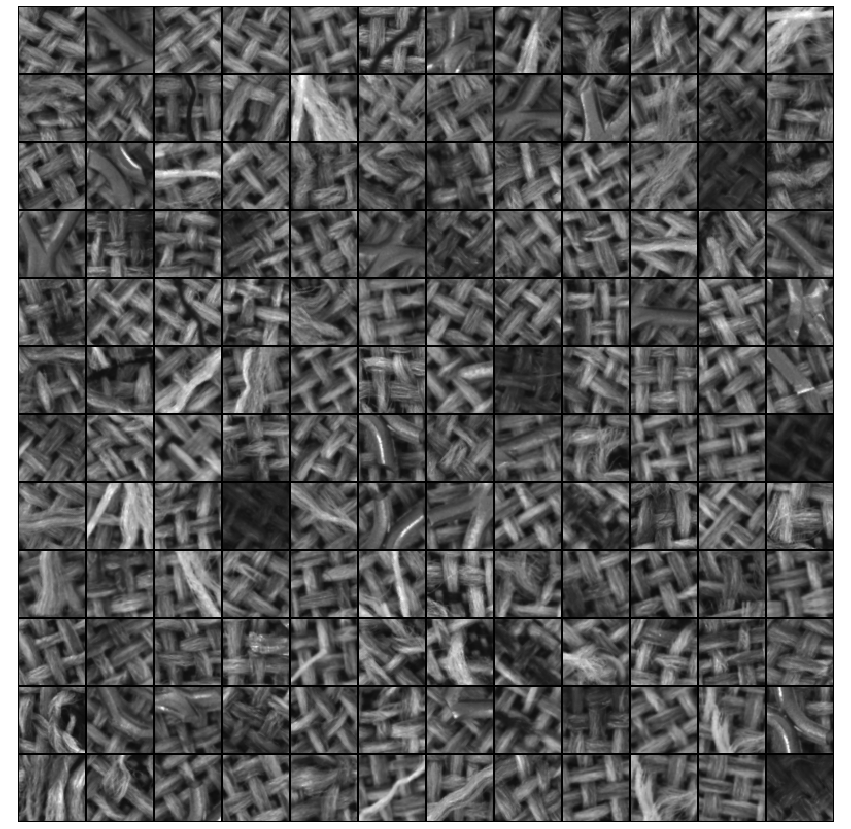

In [5]:
showImages(images, stride=2, random_display=True, invert=False)

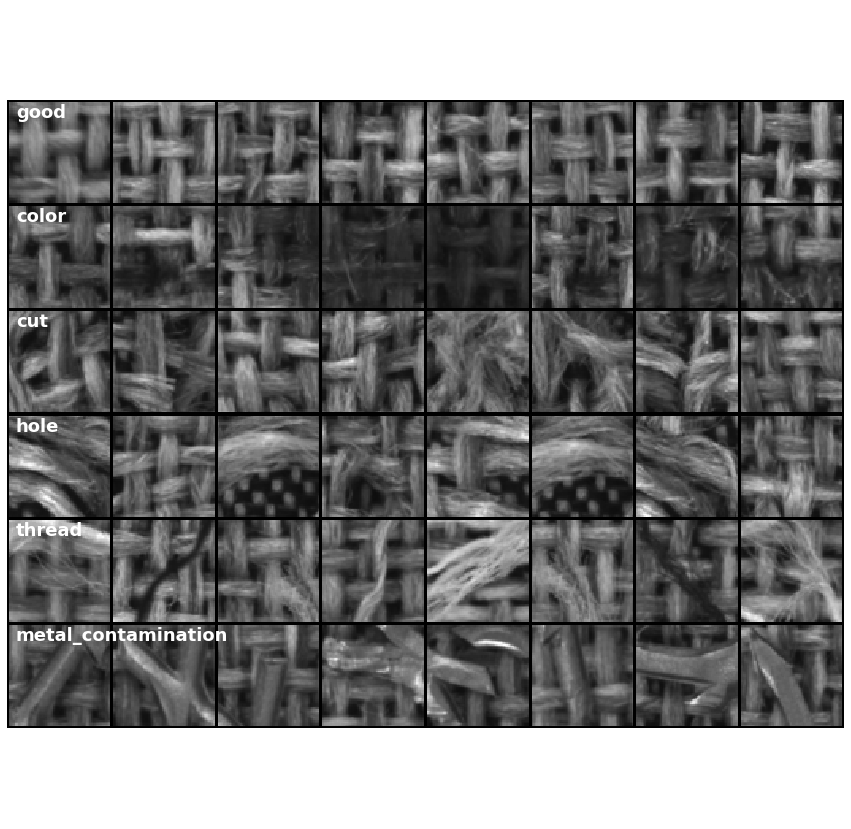

In [6]:
# Show different labels
s = images.shape
W = 8
this_arr = np.zeros((8*W, s[1], s[2]))

txt = []
for ii in range(6):
    sel = np.logical_and(labels.indication_value==ii, labels.angle==0)
    idx = np.array(labels.index[sel])[:W]
    txt.append(labels.indication_type[idx[0]])
    this_arr[W*ii:W*(ii+1)] = images[idx].squeeze(3)

showImages(this_arr, stride=2, random_display=False, invert=False, nimg=(6,W),  figsize=(15,15))
for ii in range(6):
    plt.text(5,(s[1]+2)*ii+10, txt[ii], color="w", fontsize=18, fontweight='bold')

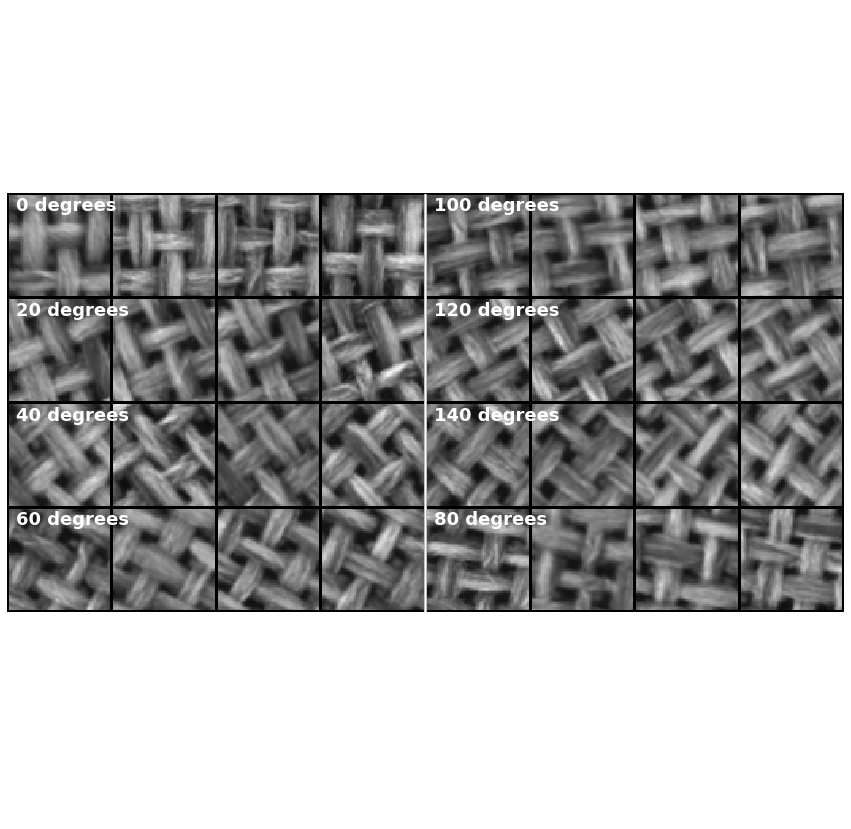

In [7]:
# Show different angles
s = images.shape
W = 4
this_arr = np.zeros((8*W, s[1], s[2]))

angles = [0,100,20,120,40,140,60,80]
for ii,angle in enumerate(angles):
    sel = np.logical_and(labels.indication_value==0, labels.angle==angle)
    idx = np.array(labels.index[sel])[:W]
    this_arr[W*ii:W*(ii+1)] = images[idx].squeeze(3)


showImages(this_arr, stride=2, random_display=False, invert=False, nimg=(4,W*2))
x = 4*s[2]+8
plt.plot([x,x,x-1,x-1],[0,x,x,0],'w')
for ii,angle in enumerate(angles):
    h_shift = 5 + (ii%2)*4*(s[2]+2)
    v_shift = 10 + (ii//2)*(s[1]+2)
    plt.text(h_shift,v_shift, "%d degrees"%angle, color="w", fontsize=18, fontweight='bold')

## With 32x32 images

In [8]:
datapath = './textures'
datafile = 'train32'
hf = h5py.File(os.path.join(datapath ,datafile + '.h5'), 'r')
images = hf['images'][:]
hf.close()
labels = pd.read_csv(os.path.join(datapath, datafile + '.csv')) #.set_index("index")

labels.head()

,index,angle,indication_type,indication_value,split
0,48000,40,good,0,train
1,48001,60,good,0,train
2,48002,20,good,0,train
3,48003,40,good,0,train
4,48004,20,good,0,train


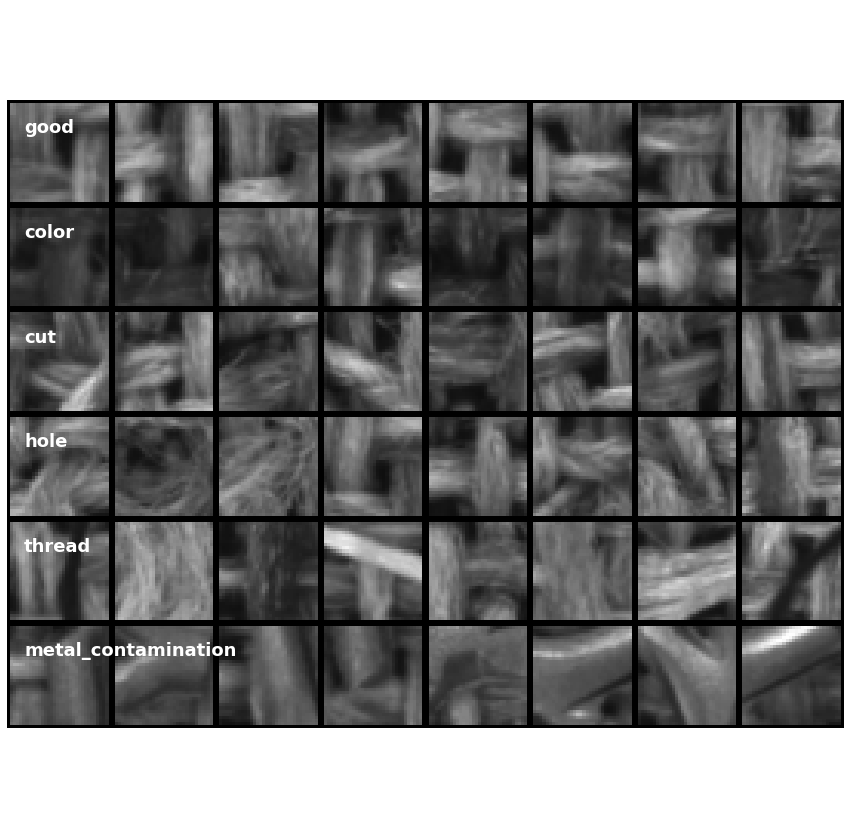

In [9]:
# Show different labels
s = images.shape
W = 8
this_arr = np.zeros((8*W, s[1], s[2]))

txt = []
for ii in range(6):
    sel = np.logical_and(labels.indication_value==ii, labels.angle==0)
    idx = np.array(labels.index[sel])[:W]
    txt.append(labels.indication_type[idx[0]])
    this_arr[W*ii:W*(ii+1)] = images[idx].squeeze(3)

showImages(this_arr, stride=2, random_display=False, invert=False, nimg=(6,W),  figsize=(15,15))
for ii in range(6):
    plt.text(5,(s[1]+2)*ii+10, txt[ii], color="w", fontsize=18, fontweight='bold')

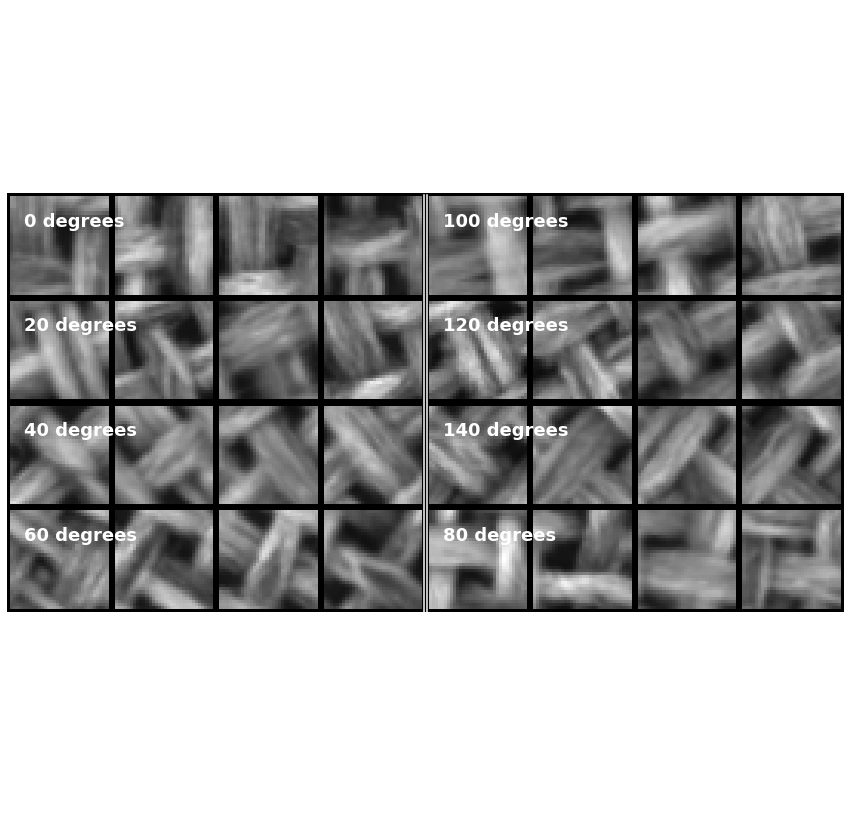

In [10]:
# Show different angles
s = images.shape
W = 4
this_arr = np.zeros((8*W, s[1], s[2]))

angles = [0,100,20,120,40,140,60,80]
for ii,angle in enumerate(angles):
    sel = np.logical_and(labels.indication_value==0, labels.angle==angle)
    idx = np.array(labels.index[sel])[:W]
    this_arr[W*ii:W*(ii+1)] = images[idx].squeeze(3)


showImages(this_arr, stride=2, random_display=False, invert=False, nimg=(4,W*2))
x = 4*s[2]+8
plt.plot([x,x,x-1,x-1],[0,x,x,0],'w')
for ii,angle in enumerate(angles):
    h_shift = 5 + (ii%2)*4*(s[2]+2)
    v_shift = 10 + (ii//2)*(s[1]+2)
    plt.text(h_shift,v_shift, "%d degrees"%angle, color="w", fontsize=18, fontweight='bold')

## With 64x64 test images

In [11]:
datapath = './textures'
datafile = 'test64'
hf = h5py.File(os.path.join(datapath ,datafile + '.h5'), 'r')
images = hf['images'][:]
hf.close()
labels = pd.read_csv(os.path.join(datapath, datafile + '.csv')) #.set_index("index")

labels.head()

,index,angle,indication_type,indication_value,split
0,0,100,good,0,test
1,1,40,good,0,test
2,2,40,good,0,test
3,3,120,good,0,test
4,4,20,good,0,test


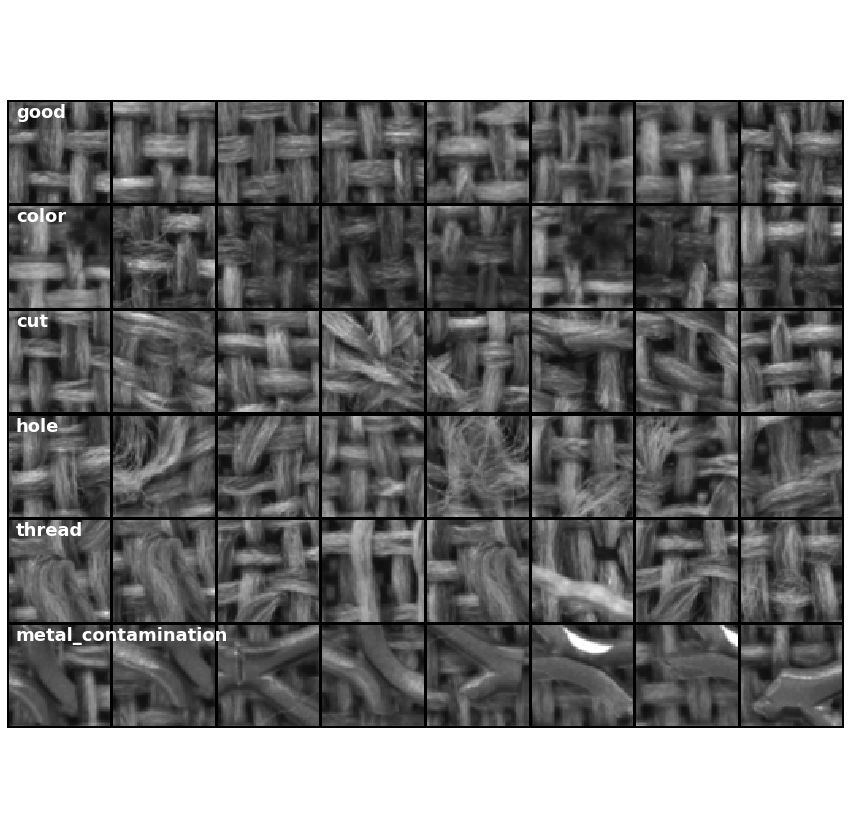

In [12]:
# Show different labels
s = images.shape
W = 8
this_arr = np.zeros((8*W, s[1], s[2]))

txt = []
for ii in range(6):
    sel = np.logical_and(labels.indication_value==ii, labels.angle==0)
    idx = np.array(labels.index[sel])[:W]
    txt.append(labels.indication_type[idx[0]])
    this_arr[W*ii:W*(ii+1)] = images[idx].squeeze(3)

showImages(this_arr, stride=2, random_display=False, invert=False, nimg=(6,W),  figsize=(15,15))
for ii in range(6):
    plt.text(5,(s[1]+2)*ii+10, txt[ii], color="w", fontsize=18, fontweight='bold')

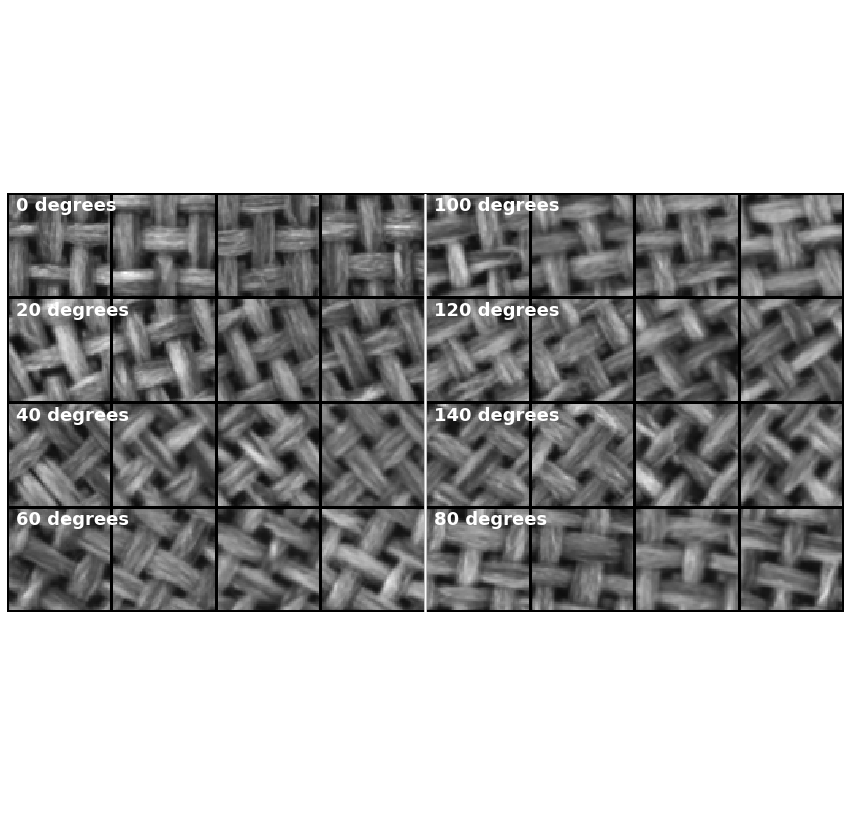

In [13]:
# Show different angles
s = images.shape
W = 4
this_arr = np.zeros((8*W, s[1], s[2]))

angles = [0,100,20,120,40,140,60,80]
for ii,angle in enumerate(angles):
    sel = np.logical_and(labels.indication_value==0, labels.angle==angle)
    idx = np.array(labels.index[sel])[:W]
    this_arr[W*ii:W*(ii+1)] = images[idx].squeeze(3)


showImages(this_arr, stride=2, random_display=False, invert=False, nimg=(4,W*2))
x = 4*s[2]+8
plt.plot([x,x,x-1,x-1],[0,x,x,0],'w')
for ii,angle in enumerate(angles):
    h_shift = 5 + (ii%2)*4*(s[2]+2)
    v_shift = 10 + (ii//2)*(s[1]+2)
    plt.text(h_shift,v_shift, "%d degrees"%angle, color="w", fontsize=18, fontweight='bold')